                               ** Attention mechanism in keras **


This notbook tries to explain what often-quoted Attention mechanism is. we will discuss how a simple Attention model can be implemented in Keras. The purpose of this demo is to show how a simple Attention layer can be implemented in keras. The NLP field adressed here is sentiment analysis. The dataset is publically availble  [here](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences)



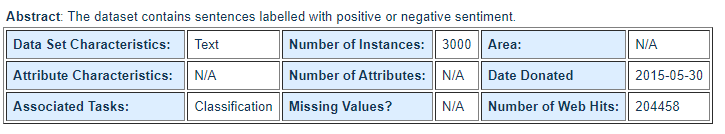

# What is Attention?
When we think about the English word “Attention”, we know that it means directing your focus at something and taking greater notice. The Attention mechanism in Deep Learning is based off this concept of directing your focus, and it pays greater attention to certain factors when processing the data.

In broad terms, Attention is one component of a network’s architecture, and is in charge of managing and quantifying the interdependence:

Between the input and output elements (General Attention)
Within the input elements (Self-Attention)
Let me give you an example of how Attention works in a translation task. Say we have the sentence “How was your day”, which we would like to translate to the French version - “Comment se passe ta journée”. What the Attention component of the network will do for each word in the output sentence is map the important and relevant words from the input sentence and assign higher weights to these words, enhancing the accuracy of the output prediction.




In [22]:
import os,re
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
print('tensorflow version:',tf.__version__)
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, InputLayer, Dense, Embedding, Input
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt


tensorflow version: 2.4.1


In [23]:
#import datasets
imdb=pd.read_csv('../input/sentiment-labelled-sentences-data-set/sentiment labelled sentences/amazon_cells_labelled.txt', sep="	", )
imdb.columns=['text','label']
print(imdb.shape)
amazon=pd.read_csv('../input/sentiment-labelled-sentences-data-set/sentiment labelled sentences/imdb_labelled.txt', sep="	", header = None)
amazon.columns=['text','label']
print(amazon.shape)
yelp=pd.read_csv('../input/sentiment-labelled-sentences-data-set/sentiment labelled sentences/yelp_labelled.txt', sep="	", header = None)
yelp.columns=['text','label']
print(yelp.shape)
#concatenation 
data=pd.concat([imdb,amazon,yelp])

(999, 2)
(748, 2)
(1000, 2)


In [24]:
data.head(5)

,text,label
0,"Good case, Excellent value.",1
1,Great for the jawbone.,1
2,Tied to charger for conversations lasting more...,0
3,The mic is great.,1
4,I have to jiggle the plug to get it to line up...,0


In [25]:
print(data.shape)

(2747, 2)


In [26]:
#cleaning text
def clean_text(dataset):
    
    for i in range(dataset.shape[0]):
        sentence=dataset.iloc[i,0]
        sentence=re.sub('[^A-Za-z0-9]+', ' ', str(sentence).lower()).strip()
        dataset.iloc[i,0]=sentence
        #print(sentence)
        
    return data

corpus=clean_text(data)

In [27]:
print(corpus.shape[0])

2747


In [28]:
corpus.head()

,text,label
0,good case excellent value,1
1,great for the jawbone,1
2,tied to charger for conversations lasting more...,0
3,the mic is great,1
4,i have to jiggle the plug to get it to line up...,0


1    1386
0    1361
Name: label, dtype: int64

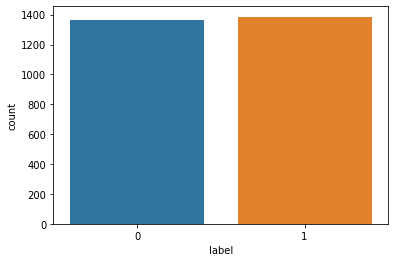

In [29]:
#Balanced dataset
sns.countplot(x="label", data=corpus)
corpus['label'].value_counts()

In [30]:
tokenizer=Tokenizer(num_words=1000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus['text'])
text_matrix=tokenizer.texts_to_sequences(corpus['text'])

In [31]:
len_mat=[]
for i in range(len(text_matrix)):
    len_mat.append(len(text_matrix[i]))
text_pad = pad_sequences(text_matrix, maxlen=32, padding='post')    

In [32]:
#Model1 without attention
vocab_lenght=3000
"""
model1=tf.keras.Sequential([
    InputLayer(input_shape=(text_pad.shape[1],)),
    Embedding(input_dim=vocab_lenght+1, output_dim=32, embeddings_initializer='uniform'),
    LSTM(100,dropout=0.3,recurrent_dropout=0.2, ),
    Dense(1,activation='sigmoid')    
]
)
"""
inputs1=Input(shape=(text_pad.shape[1],))
x1=Embedding(input_dim=vocab_lenght+1,output_dim=32,\
             input_length=text_pad.shape[1],embeddings_regularizer=tf.keras.regularizers.l2(.001))(inputs1)
x1=LSTM(100,dropout=0.3,recurrent_dropout=0.2)(x1)
outputs1=Dense(1,activation='sigmoid')(x1)
model1=Model(inputs1,outputs1)

model1.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 32, 32)            96032     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 149,333
Trainable params: 149,333
Non-trainable params: 0
_________________________________________________________________


In [33]:
model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'] )

In [38]:
#Training model 1 without Attention
x_train=np.array(text_pad)
y_train=np.array(corpus['label'])
history=model1.fit(x_train,y_train,batch_size=64,epochs=10,verbose=1,shuffle=True,validation_split=0.2).history

Epoch 1/10
35/35 [==============================] - 2s 50ms/step - loss: 0.6921 - accuracy: 0.5248 - val_loss: 0.6808 - val_accuracy: 0.5527
Epoch 2/10
35/35 [==============================] - 2s 50ms/step - loss: 0.6313 - accuracy: 0.6896 - val_loss: 0.5492 - val_accuracy: 0.7545
Epoch 3/10
35/35 [==============================] - 2s 49ms/step - loss: 0.4261 - accuracy: 0.8343 - val_loss: 0.4806 - val_accuracy: 0.7691
Epoch 4/10
35/35 [==============================] - 2s 49ms/step - loss: 0.3392 - accuracy: 0.8789 - val_loss: 0.4797 - val_accuracy: 0.7509
Epoch 5/10
35/35 [==============================] - 2s 51ms/step - loss: 0.3412 - accuracy: 0.8930 - val_loss: 0.5240 - val_accuracy: 0.7964
Epoch 6/10
35/35 [==============================] - 2s 50ms/step - loss: 0.3099 - accuracy: 0.9008 - val_loss: 0.5073 - val_accuracy: 0.7782
Epoch 7/10
35/35 [==============================] - 2s 50ms/step - loss: 0.2709 - accuracy: 0.9203 - val_loss: 0.4970 - val_accuracy: 0.7982
Epoch 8/10
35

# About 77% of accuracy has been observed with basic LSTM and without Attention. Lets now implement an Attetion layer and add it to the LSMT-Based model. 

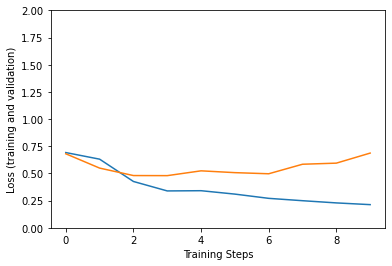

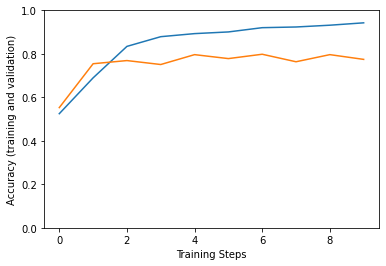

In [39]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history["loss"])
plt.plot(history["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history["accuracy"])
plt.plot(history["val_accuracy"])

In [47]:
from keras.layers import Layer
import keras.backend as K
class attention(Layer):
    
    """This class implents the attention mechanism layer: We will define a class named Attention as a derived class of the Layer class. We need to define four functions as per the Keras custom layer generation rule. 
    These are build(),call (), compute_output_shape() and get_config()."""
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)
        
        
    """Inside build (), we will define our weights and biases, i.e., Wa and B . 
    If the previous LSTM layer’s output shape is (None, 32, 100)
    then our output weight should be (100, 1) and bias should be (100, 1) dimensional."""
    def build(self,input_shape):
        self.w=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")
        super(attention,self).build(input_shape)
        
        
    """Inside call (), we will write the main logic of Attention. We simply must create a Multi-Layer Perceptron (MLP). 
    Therefore, we will take the dot product of weights and inputs followed by the addition of bias terms. 
    After that, we apply a ‘tanh’ followed by a softmax layer. This softmax gives the alignment scores. 
    Its dimension will be the number of hidden states in the LSTM, i.e., 32 in this case. 
    Taking its dot product along with the hidden states will provide the context vector:"""    
    def call(self,x):
        et=K.squeeze(k.tanh(K.dot(x,self.w)+self.b), axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return k.sum(output,axis=1)
    
    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])
    "The get_config() method collects the input shape and other information about the model."""
    def get_config(self):
        return super(attention,self).get_config()        

In [51]:
#The new model with attention mechanism
inputs=Input(shape=(text_pad.shape[1],))
x=Embedding(input_dim=vocab_lenght+1,output_dim=32,\
             input_length=text_pad.shape[1],embeddings_regularizer=tf.keras.regularizers.l2(.001))(inputs)
x1=LSTM(100,return_sequences=True,dropout=0.3,recurrent_dropout=0.2)(x)
atte_layer=attention()(x1)
outputs=Dense(1,activation='sigmoid',trainable=True)(atte_layer)
model=Model(inputs,outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 32, 32)            96032     
_________________________________________________________________
lstm_6 (LSTM)                (None, 32, 100)           53200     
_________________________________________________________________
attention_4 (attention)      (None, 100)               132       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 149,465
Trainable params: 149,465
Non-trainable params: 0
_________________________________________________________________


In [55]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']  )
history1=model.fit(x_train,y_train,epochs=10, validation_split=0.2,verbose=1,batch_size=64,shuffle=True).history

Epoch 1/10
35/35 [==============================] - 5s 63ms/step - loss: 0.2357 - accuracy: 0.9279 - val_loss: 0.4853 - val_accuracy: 0.8164
Epoch 2/10
35/35 [==============================] - 2s 52ms/step - loss: 0.2060 - accuracy: 0.9326 - val_loss: 0.4972 - val_accuracy: 0.8273
Epoch 3/10
35/35 [==============================] - 2s 53ms/step - loss: 0.1866 - accuracy: 0.9468 - val_loss: 0.5588 - val_accuracy: 0.8200
Epoch 4/10
35/35 [==============================] - 2s 53ms/step - loss: 0.1897 - accuracy: 0.9431 - val_loss: 0.6217 - val_accuracy: 0.8073
Epoch 5/10
35/35 [==============================] - 2s 51ms/step - loss: 0.2077 - accuracy: 0.9374 - val_loss: 0.6486 - val_accuracy: 0.8073
Epoch 6/10
35/35 [==============================] - 2s 52ms/step - loss: 0.1582 - accuracy: 0.9542 - val_loss: 0.5392 - val_accuracy: 0.8273
Epoch 7/10
35/35 [==============================] - 2s 52ms/step - loss: 0.1730 - accuracy: 0.9583 - val_loss: 0.5566 - val_accuracy: 0.8055
Epoch 8/10
35

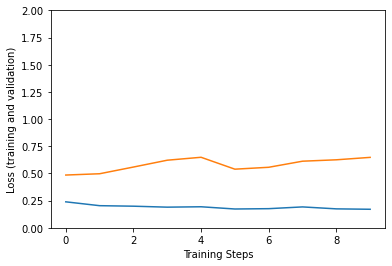

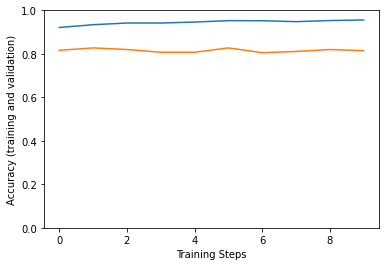

In [56]:
plt.figure()
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(history1["loss"])
plt.plot(history1["val_loss"])

plt.figure()
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(history1["accuracy"])
plt.plot(history1["val_accuracy"])

# Accuracy is now better about 0.8145
# Please pay moer attention to tha attention mechanism !!!
# Enjoy !!!